<a href="https://colab.research.google.com/github/Moriblo/MVP_Spt4_EngSoft/blob/main/MVP_SPT4_EngSoft_MLFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engenharia de Software - MVP Sprint 4

## Coleta de Dados

### _Requirements

In [6]:
!pip install gdown

In [7]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from google.colab import files
from IPython.display import display, HTML
from scipy import stats

### _Carga dos Datasets

In [8]:
# Informa a URL de importação do dataset
id_arquivo_1 = '1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG'
id_arquivo_2 = '1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD'
id_arquivo_cad = '1yO9-XahOdUOj00g9SyBBETASc84mRNtt'

# URLs para download direto dos arquivos
url_1 = f'https://drive.google.com/uc?id={id_arquivo_1}'
url_2 = f'https://drive.google.com/uc?id={id_arquivo_2}'
url_cad = f'https://drive.google.com/uc?id={id_arquivo_cad}'

# Faça o download dos arquivos
gdown.download(url_1, 'arquivo1.csv', quiet=False)
gdown.download(url_2, 'arquivo2.csv', quiet=False)
gdown.download(url_cad, 'arquivocad.csv', quiet=False)

# Lê o arquivo
df_1 = pd.read_csv('arquivo1.csv', delimiter=';')
df_2 = pd.read_csv('arquivo2.csv', delimiter=';')
df_cad = pd.read_csv('arquivocad.csv', delimiter=';')

# df_1 é o dataframe com os dados performance diária do mês M-1
# df_2 é o dataframe com os dados de performance diária do mês M
# df_cad é o dataframe com os dados de cadastro dos Fundos de Investimento

Downloading...
From: https://drive.google.com/uc?id=1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG
To: /content/arquivo1.csv
100%|██████████| 46.2M/46.2M [00:00<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD
To: /content/arquivo2.csv
100%|██████████| 49.0M/49.0M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yO9-XahOdUOj00g9SyBBETASc84mRNtt
To: /content/arquivocad.csv
100%|██████████| 3.59M/3.59M [00:00<00:00, 62.3MB/s]


## _RESET DE DATAFRAME

In [19]:
df_m1 = df_1 # para não necessitar realizar carga a cada mudança no código
df_m2 = df_2 # para não necessitar realizar carga a cada mudança no código

## Pré-processamento

### _Limpeza

#### __Redundâncias

In [20]:
# Adequando VL_QUOTA à quantidade de casas decimais informada no Dicionário de
# Dados do dataset de origem
df_m1['VL_QUOTA'] = df_m1['VL_QUOTA'].astype(str).str.replace('.', '')
df_m1['VL_QUOTA'] = df_m1['VL_QUOTA'].astype(float)
df_m1['VL_QUOTA'] = df_m1['VL_QUOTA'] / (10**12)

df_m2['VL_QUOTA'] = df_m2['VL_QUOTA'].astype(str).str.replace('.', '')
df_m2['VL_QUOTA'] = df_m2['VL_QUOTA'].astype(float)
df_m2['VL_QUOTA'] = df_m2['VL_QUOTA'] / (10**12)

# Removendo as tuplas em que VL_QUOTA seja negativo (para efeito de cálculo de
# retorno)
df_m1 = df_m1[df_m1["VL_QUOTA"] >= 0]
df_m2 = df_m2[df_m2["VL_QUOTA"] >= 0]

####### AVALIANDO OS DADOS #######

# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_1.dtypes, columns=['df_m1_dtypes'])
temp2 = pd.DataFrame(df_2.dtypes, columns=['df_m2_dtypes'])
temp3 = pd.DataFrame(df_1.count(), columns=['df_m1_count'])
temp4 = pd.DataFrame(df_2.count(), columns=['df_m2_count'])

# Criação de DataFrames temporários para armazenar as informações de shape
temp5 = pd.DataFrame([df_m1.shape], columns=['df_m1_rows', 'df_m1_cols'])
temp6 = pd.DataFrame([df_m2.shape], columns=['df_m2_rows', 'df_m2_cols'])

# Concatenação dos DataFrames lado a lado
result = pd.concat([temp1, temp2, temp3, temp4], axis=1)

# Exibição do resultado
print(result)
print()
print('* Avaliação de df_m1:')
print()
print(temp5.to_string(index=False))
display(df_m1.describe())
print()
print('* Avaliação de df_m2:')
print()
print(temp6.to_string(index=False))
display(df_m2.describe())

              df_m1_dtypes df_m2_dtypes  df_m1_count  df_m2_count
TP_FUNDO            object       object       505556       537278
CNPJ_FUNDO          object       object       505556       537278
DT_COMPTC           object       object       505556       537278
VL_TOTAL           float64      float64       505556       537278
VL_QUOTA           float64      float64       505556       537278
VL_PATRIM_LIQ      float64      float64       505556       537278
CAPTC_DIA          float64      float64       505556       537278
RESG_DIA           float64      float64       505556       537278
NR_COTST             int64        int64       505556       537278

* Avaliação de df_m1:

 df_m1_rows  df_m1_cols
     505152           9


,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,5.051520e+05,505152.000000,5.051520e+05,5.051520e+05,5.051520e+05,5.051520e+05
mean,4.213980e+08,15.997241,4.206399e+08,2.341868e+06,2.353635e+06,1.001893e+03
std,2.819297e+09,731.370739,2.816258e+09,4.613030e+07,5.334481e+07,1.645567e+04
min,-4.555807e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.535371e+07,0.000011,1.539842e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.306366e+07,0.000046,4.316420e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.558318e+08,0.000232,1.560282e+08,0.000000e+00,0.000000e+00,1.600000e+01
max,1.632093e+11,77846.126587,1.632091e+11,7.671206e+09,1.437241e+10,1.185455e+06



* Avaliação de df_m2:

 df_m2_rows  df_m2_cols
     536874           9


,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,5.368740e+05,536874.000000,5.368740e+05,5.368740e+05,5.368740e+05,5.368740e+05
mean,4.160074e+08,15.220500,4.152680e+08,2.304712e+06,2.369199e+06,9.895581e+02
std,2.789516e+09,716.679772,2.787043e+09,4.702319e+07,5.269102e+07,1.638518e+04
min,-3.073482e+08,0.000000,-4.150969e+07,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.481920e+07,0.000011,1.484767e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.167161e+07,0.000047,4.173578e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.512468e+08,0.000226,1.513313e+08,0.000000e+00,0.000000e+00,1.500000e+01
max,1.606797e+11,79284.193012,1.606795e+11,1.276418e+10,1.423898e+10,1.195044e+06


#### __Missings

In [21]:
####### MARCANDO E PREENCHENDO OS DATAFRAMES  #######
# Considerando somente os dígitos referente ao "dia" em relação a
# DT_COMPTC (Data de competência do documento)
df_m1['DT_COMPTC_DIA'] = df_m1['DT_COMPTC'].str.slice(0, 2)
df_m2['DT_COMPTC_DIA'] = df_m2['DT_COMPTC'].str.slice(0, 2)

# Definindo o index para o JOIN
df_m1.set_index(['CNPJ_FUNDO', 'DT_COMPTC_DIA'], inplace=True)
df_m2.set_index(['CNPJ_FUNDO', 'DT_COMPTC_DIA'], inplace=True)

# JOIN os dois DataFrames usando o índice
df_atrib = df_m1.join(df_m2, rsuffix='_1')

# Resetar o índice
df_atrib.reset_index(inplace=True)

# Merge entre df_3 e df_cad para classificar os CNPJs em df_3 com sua respectiva
# classe de fundo obtida de df_cad.
df_atrib = df_atrib.merge(df_cad[['CNPJ_FUNDO', 'CLASSE']], on='CNPJ_FUNDO', how='left')

# Calculando o retorno, dia a dia, do mês analisado (df_2) em relação ao
# mês anterior (df_1) na coluna RETORNO com cinco casas decimais
df_atrib['RETORNO'] = (df_atrib['VL_QUOTA_1'] - df_atrib['VL_QUOTA']).round(5)


#### __Agregação

In [22]:
####### AGREGAÇÃO NO DATAFRAME DE ATRIBUTOS (df_atrib) #######

# Mantém somente as colunas referentes ao mês anterior (M-1 -> df_1)
df_atrib = df_atrib.filter(regex='[^_1]$')

# Considerando que RETORNO > 0, É um bom investimento (SUGESTÃO = 1), caso
# contrário NÃO É um bom investimento (SUGESTÃO = 0)
df_atrib['SUGESTÃO'] = df_atrib['RETORNO'].apply(lambda x: 1 if x > 0 else 0)

# Limpa coluna RETORNO
df_atrib = df_atrib.replace(['#NOME?', '', '-Infinity'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])
df_atrib['RETORNO'] = df_atrib['RETORNO'].astype(str)
df_atrib = df_atrib.replace(['-Infinity', '-inf'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])
df_atrib = df_atrib.reset_index()

# Fazendo NR_COTST (Número de Cotistas) > 1000
df_atrib['NR_COTST'] = df_atrib['NR_COTST'].astype(int)
df_atrib = df_atrib[(df_atrib['NR_COTST'] > 1000)]

# Após avaliação dos dados, passou-se a considerar a limitação para o Valor do
# Patrimônio Líquido do Fundo acima de 1.000.000
df_atrib = df_atrib[(df_atrib['VL_PATRIM_LIQ'] > 1000000)]

# Filtrando os dados do dataframe para conter somente a CLASSE Fundo Multimercado
df_atrib = df_atrib[(df_atrib['CLASSE'] == "Fundo Multimercado")]

# Mantendo os atributos relevantes
df_atrib = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', \
                     'SUGESTÃO']]

# Converte o atributo SUGESTÃO em booleano
df_atrib['SUGESTÃO'] = df_atrib['SUGESTÃO'].astype(bool)

#### __Tratando Outliers

In [33]:
####### TRATANDO OUTLIERS COM MÉTODO IQR (Interquartile Range) #######

# Salvando a coluna 'SUGESTÃO' em um DataFrame separado antes do tratamento dos outliers
df_sugestao = df_atrib[['SUGESTÃO']]

df_iqr = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']]

# Calculando IQR
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

# Os outliers são então definidos como observações que estão abaixo de (Q1 - 1.5 * IQR)
# ou acima de (Q3 + 1.5 * IQR).
df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis=1)]

# Junte 'df_sugestao' de volta a 'df_iqr'
df_atrib = df_iqr.join(df_sugestao)

df_atrib['SUGESTÃO'] = df_atrib['SUGESTÃO'].astype(int)

#### __Apresentação dos Atributos

* Avaliação de df_atrib:
              df_atrib_dtypes  df_atrib_count
RESG_DIA              float64            3246
CAPTC_DIA             float64            3246
NR_COTST                int64            3246
VL_PATRIM_LIQ         float64            3246
SUGESTÃO                int64            3246

** SUGESTÃO
0    2720
1     526



,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,SUGESTÃO
count,3246.000000,3246.000000,3246.000000,3.246000e+03,3246.000000
mean,91449.184686,18178.908013,2681.591189,1.321048e+08,0.162046
std,135373.348301,32123.714269,1848.720062,1.275508e+08,0.368549
min,0.000000,0.000000,1001.000000,1.347824e+06,0.000000
25%,0.000000,0.000000,1317.000000,3.406963e+07,0.000000
50%,24072.610000,1100.000000,2027.000000,9.329863e+07,0.000000
75%,128566.635000,20521.810000,3373.000000,1.843076e+08,0.000000
max,588588.900000,142627.100000,9323.000000,5.849075e+08,1.000000


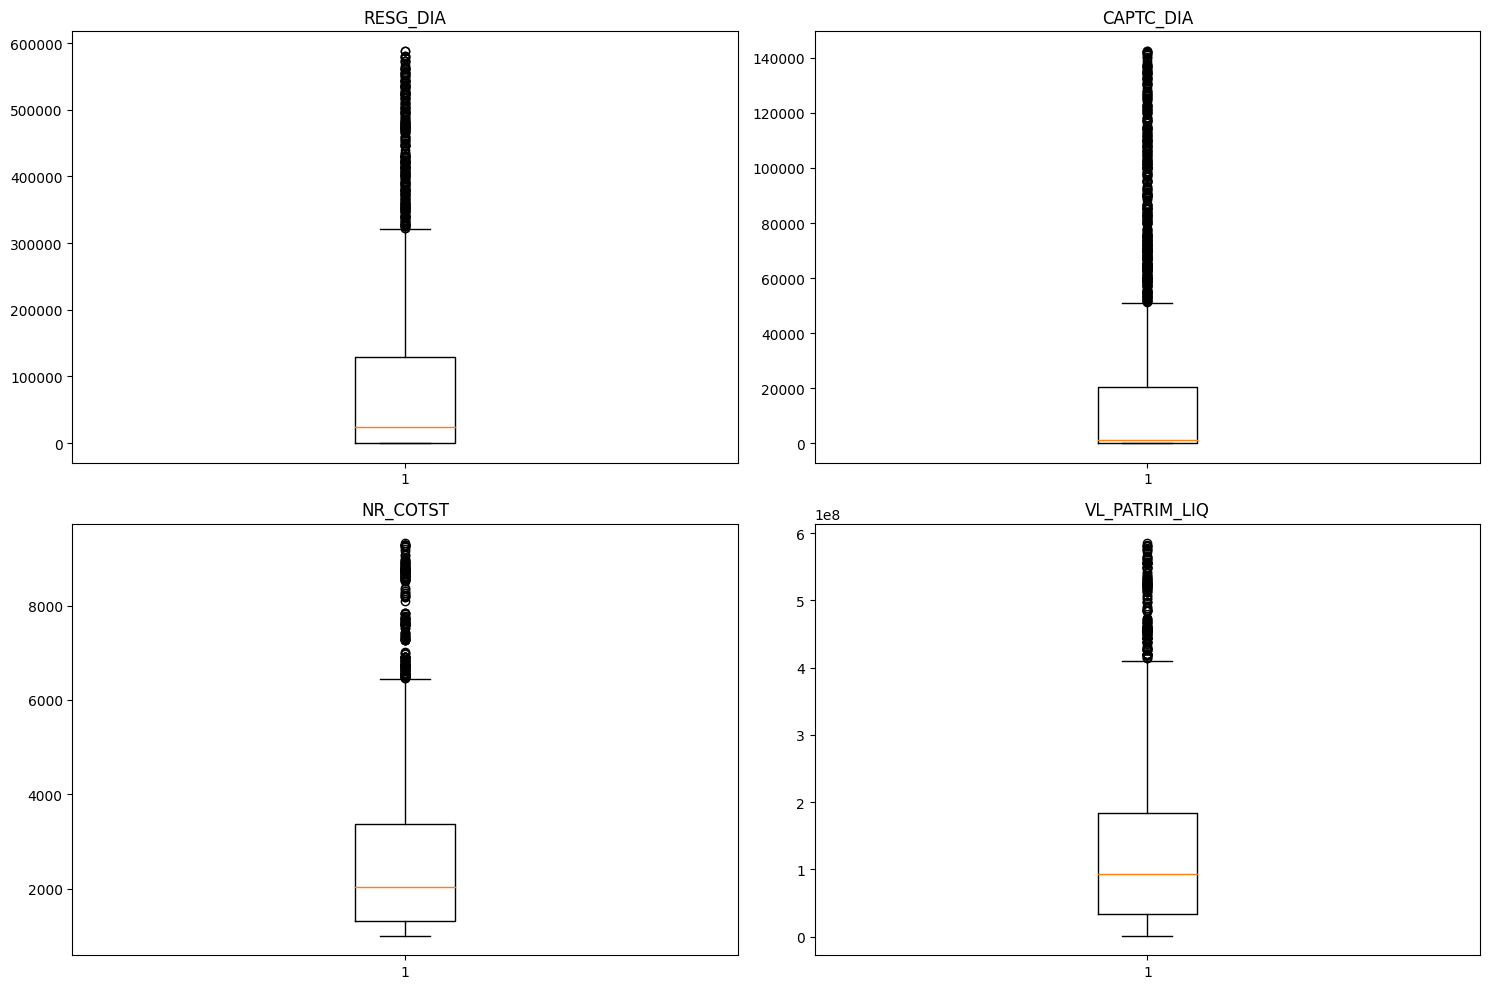

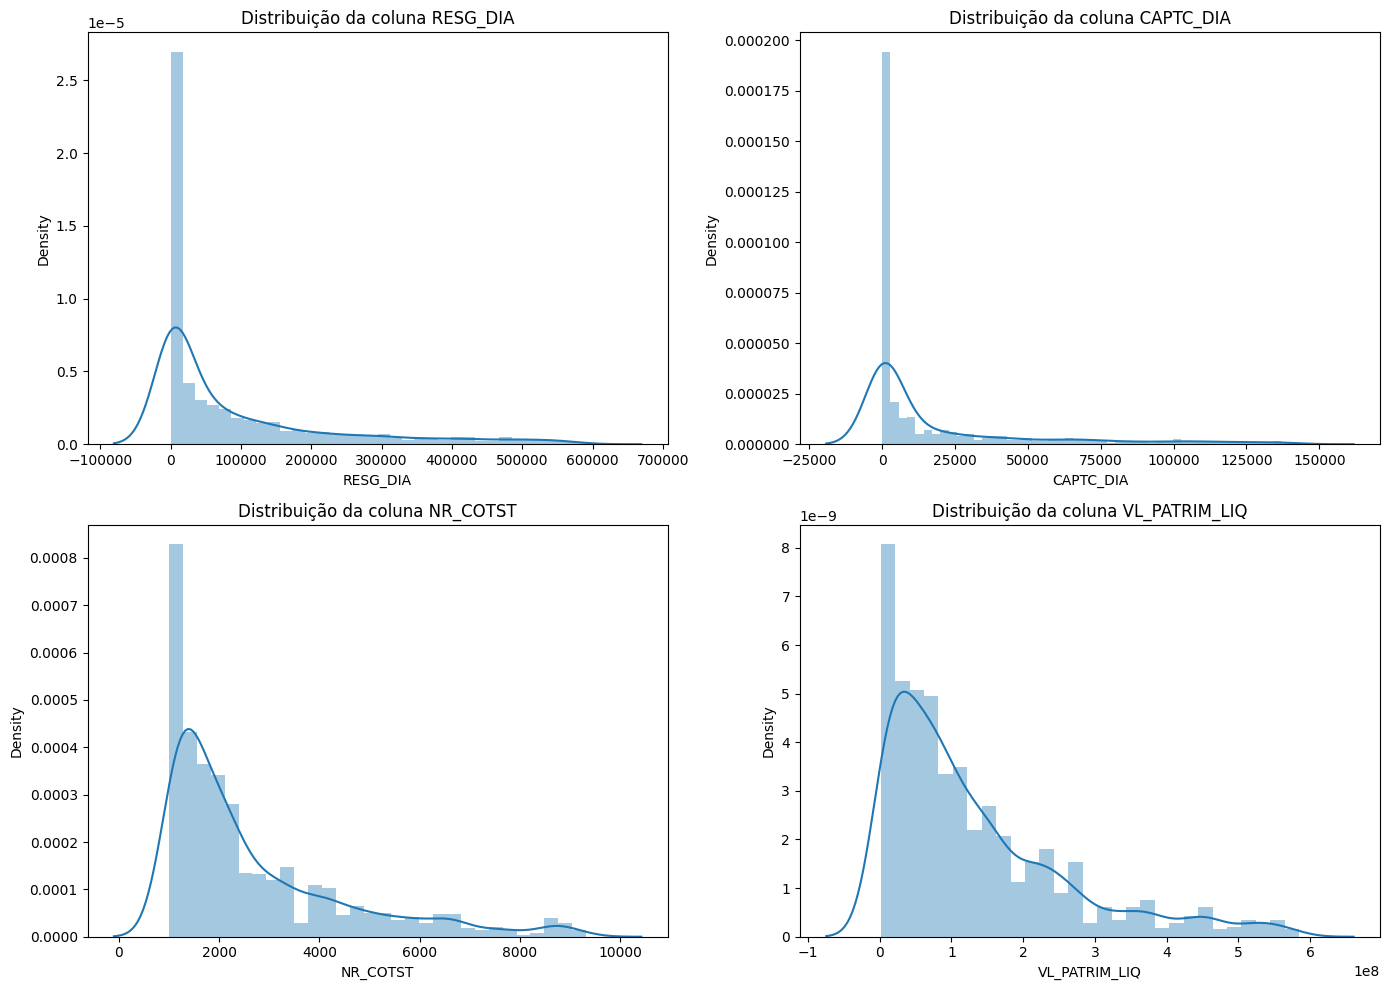

In [34]:
####### AVALIANDO OS DADOS #######

### DADOS TABELADOS ###

# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_atrib.dtypes, columns=['df_atrib_dtypes'])
temp2 = pd.DataFrame(df_atrib.count(), columns=['df_atrib_count'])

# Criação de DataFrames temporários para armazenar as informações de shape
temp3 = pd.DataFrame([df_atrib.shape])

# Concatenação dos DataFrames lado a lado
result = pd.concat([temp1, temp2], axis=1)

# Comportamento de SUGESTÃO
counts = df_atrib['SUGESTÃO'].value_counts()

# Exibição do resultado
print("* Avaliação de df_atrib:")
print(result)
print()
print("** SUGESTÃO")
print(counts.to_string(dtype=False))
print()
display(df_atrib.describe())

### BOXPLOT ###

df_box = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', \
                     'VL_PATRIM_LIQ']]

cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', \
                     'VL_PATRIM_LIQ']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, col in enumerate(cols):
    ax = axs[i//2, i%2]  # Determina a posição do subplot
    ax.boxplot(df_box[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

### DISTRIBUIÇÃO LINEAR ###

# Lista das colunas a visualizar
cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']

# Cria uma figura com 2 linhas e 2 colunas de subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Para cada coluna, cria um gráfico de distribuição linear
for i, col in enumerate(cols):
    sns.distplot(df_atrib[col], ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title('Distribuição da coluna {}'.format(col))

plt.tight_layout()
plt.show()

### _Separação em conjunto de treino e conjunto de teste com holdout

In [45]:
####### DEFININDO PARÂMETROS DO CONJUNTO DE TESTES #######

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_atrib.values
X = array[:,0:4]
y = array[:,4]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.820876 (0.016273)
CART: 0.773488 (0.018882)
NB: 0.837827 (0.001110)
SVM: 0.837827 (0.001110)


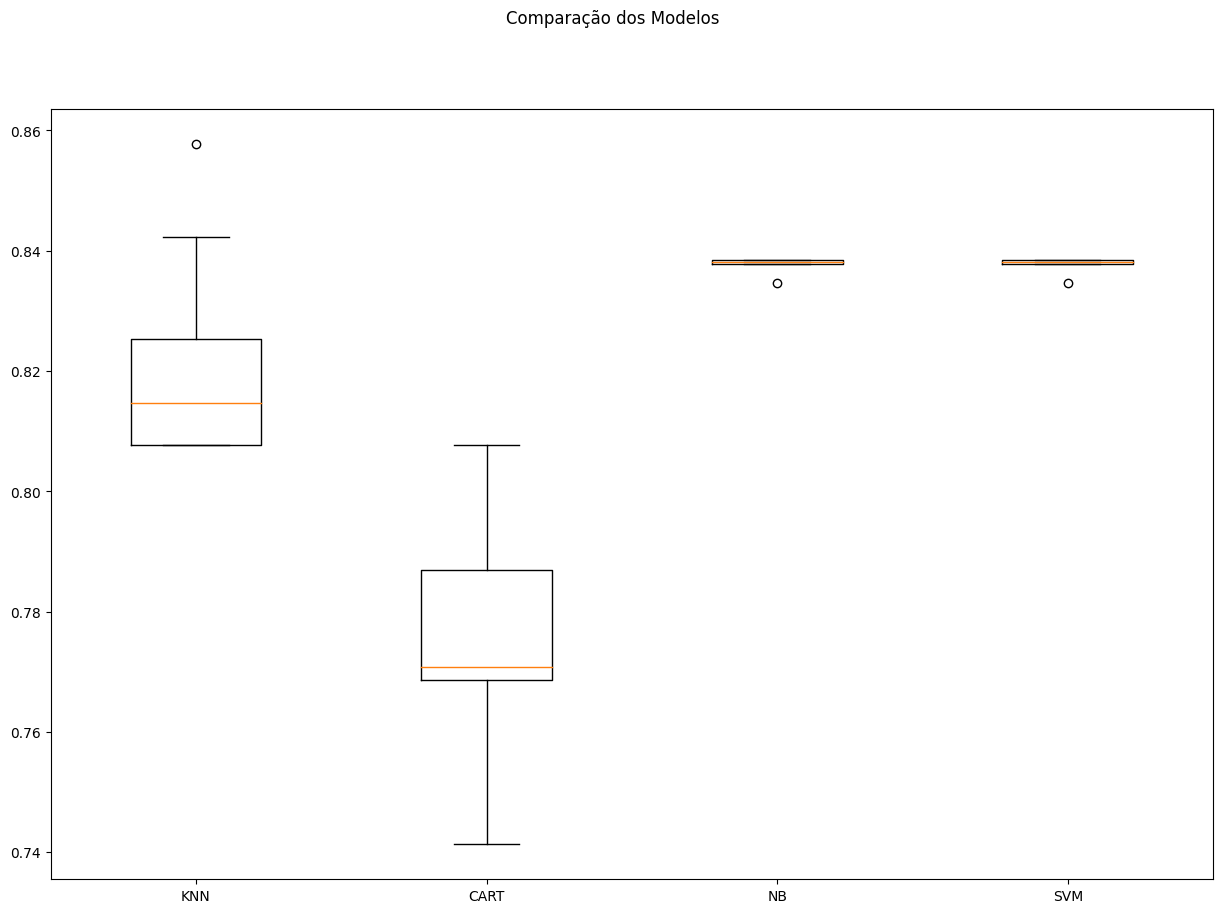

In [46]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.821 (0.016)
CART-orig: 0.773 (0.019)
NB-orig: 0.838 (0.001)
SVM-orig: 0.838 (0.001)
KNN-padr: 0.823 (0.018)
CART-padr: 0.774 (0.018)
NB-padr: 0.838 (0.001)
SVM-padr: 0.838 (0.001)
KNN-norm: 0.823 (0.017)
CART-norm: 0.773 (0.020)
NB-norm: 0.838 (0.001)
SVM-norm: 0.838 (0.001)


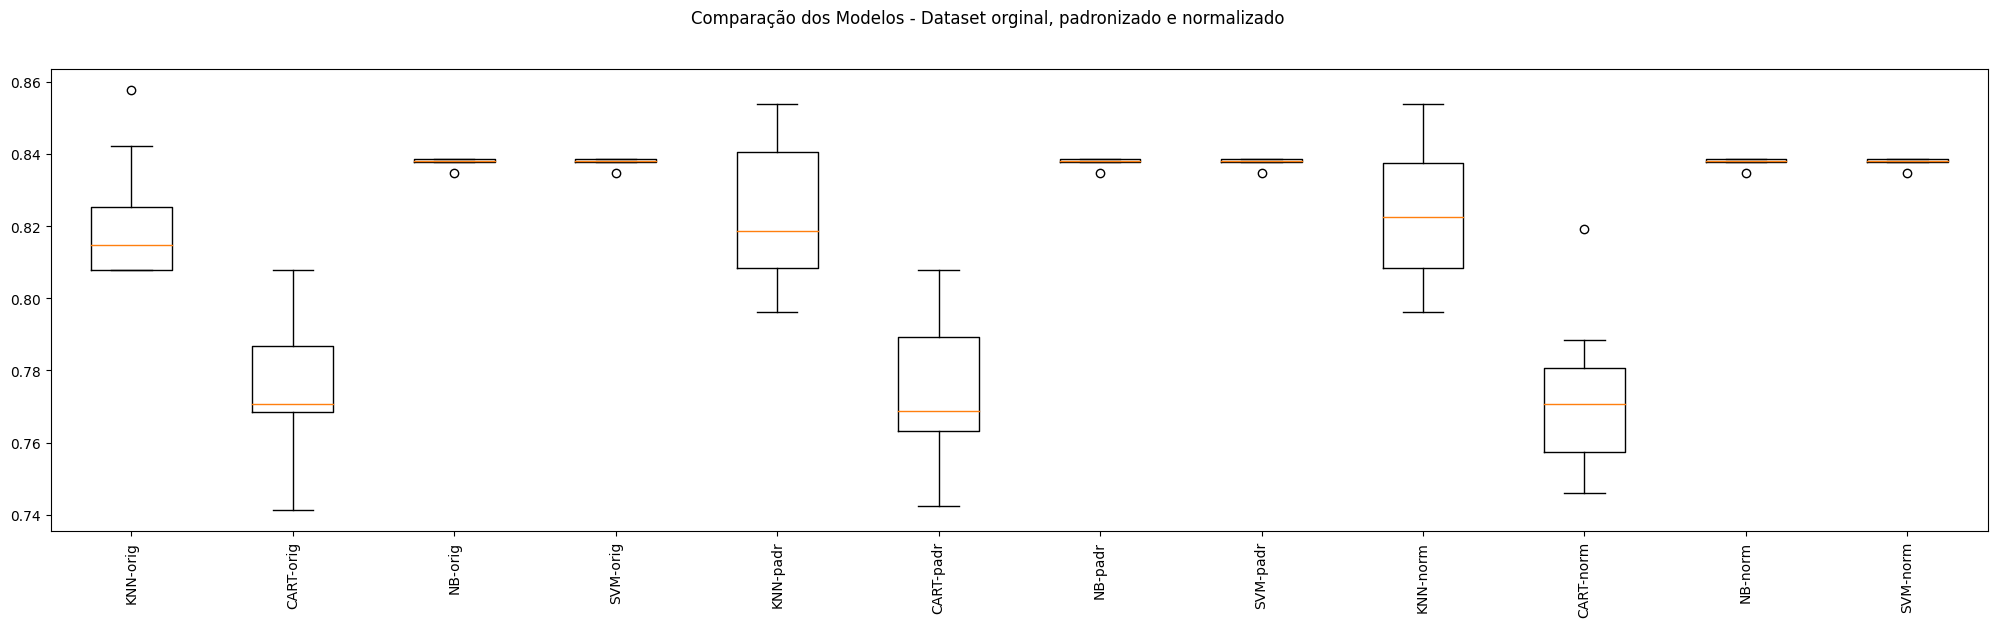

In [48]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [49]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.838980 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 21}
Sem tratamento de missings: knn-padr - Melhor: 0.841668 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}
Sem tratamento de missings: knn-norm - Melhor: 0.842052 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}


## Finalização do Modelo

In [50]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=7)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.8461538461538461


In [51]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

## Simulando a aplicação do modelo em dados não vistos

In [249]:
# Novos dados - não sabemos a classe!
data = {'RESG_DIA':  [1, 9, 5],
        'CAPTC_DIA': [90, 100, 110],
        'NR_COTST': [50, 60, 50],
        'VL_PATRIM_LIQ': [30, 30, 30],
        }

atributos = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:4].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

ValueError: ignored

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)